In [16]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # <-- Thêm StandardScaler
from sklearn.linear_model import LogisticRegression # <-- Thay đổi mô hình
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

In [17]:
print("Bắt đầu quá trình huấn luyện mô hình (Logistic Regression)...")

# --- 1. Định nghĩa Cấu trúc Dữ liệu (Dựa trên adult.names) ---

# Giả sử file train_model.py nằm ở thư mục gốc, bên cạnh thư mục 'assets'
DATA_FILE = '../data/adult.data'
MODEL_DIR = Path('../assets/model_unemployment')
MODEL_DIR.mkdir(parents=True, exist_ok=True) # Tạo thư mục nếu chưa có

# Đường dẫn lưu mô hình và các thành phần liên quan
UNEMPLOYMENT_MODEL_PATH = MODEL_DIR / 'unemployment_model.joblib'
UNEMPLOYMENT_SCALER_PATH = MODEL_DIR / 'unemployment_scaler.joblib'
UNEMPLOYMENT_COLUMNS_PATH = MODEL_DIR / 'unemployment_columns.joblib'
UNEMPLOYMENT_CHART_PATH = MODEL_DIR / 'unemployment_feature_importance.png'

# Tên cột
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

# Định nghĩa tất cả các hạng mục có thể có, bao gồm '?'
categorical_features = {
    'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked', '?'],
    'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse', '?'],
    'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces', '?'],
    'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried', '?'],
    'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black', '?'],
    'sex': ['Female', 'Male', '?'],
    'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands', '?']
}

Bắt đầu quá trình huấn luyện mô hình (Logistic Regression)...


In [18]:
# --- 2. Tải và Tiền xử lý Dữ liệu ---

try:
    df = pd.read_csv(DATA_FILE, header=None, names=columns, sep=',\s*', engine='python')
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu tại: {DATA_FILE}")
    exit()

print("Đã tải dữ liệu, bắt đầu tiền xử lý...")

# Bỏ các cột không cần thiết/thừa thãi
df_processed = df.drop(['fnlwgt', 'education'], axis=1)

# Định nghĩa cacs giá trị biểu thị 'thất nghiệp'
unemployed_values = ['Without-pay', 'Never-worked']

# Tạo cột nhãn mới: 1 - Thất nghiệp, 0 - Có việc làm
df_processed['unemployed_status'] = df_processed['workclass'].apply(
    lambda x: 1 if x.strip() in unemployed_values else 0
)

# Tách X (đặc trưng) và y (nhãn)
y = df_processed['unemployed_status'] 
X = df_processed.drop(['income', 'unemployed_status'], axis=1)

print(f"Đã tạo nhãn 'Thất nghiệp'. Tỷ lệ thất nghiệp trong dữ liệu: {y.mean()*100:.2f}%")

# Xóa 'workclass' vì nó đã được sử dụng để tạo nhãn
X = X.drop(['workclass'], axis=1)
# Xóa 'workclass' khỏi các cột cần OHE nếu có
categorical_features.pop('workclass', None) 
print("Đã xóa 'workclass' khỏi tập X để tránh rò rỉ dữ liệu.")
#Kỹ thuật đặc trưng
X['net_capital'] = X['capital-gain'] - X['capital-loss']
X = X.drop(['capital-gain', 'capital-loss'], axis=1)

# 2. Rời rạc hóa 'age'
age_bins = [16, 25, 40, 55, 65, 100]
age_labels = ['Age_17-25', 'Age_26-40', 'Age_41-55', 'Age_56-65', 'Age_66+']
X['age_group'] = pd.cut(X['age'], bins=age_bins, labels=age_labels, right=True)
X = X.drop('age', axis=1)


# Cập nhật danh sách các cột hạng mục
categorical_features_keys = list(categorical_features.keys())
categorical_features_keys.append('age_group')

# Áp dụng kiểu Categorical Dtype (trước OHE)
for col in categorical_features_keys:
    if col in X.columns:
        if col in categorical_features:
            cats = categorical_features[col]
            cat_type = pd.CategoricalDtype(categories=cats, ordered=False)
            X[col] = X[col].astype(cat_type)
        elif col == 'age_group':
            cat_type = pd.CategoricalDtype(categories=age_labels, ordered=False)
            X[col] = X[col].astype(cat_type)

# Chạy One-Hot Encoding
X_processed = pd.get_dummies(X, columns=categorical_features_keys, drop_first=True)

# --- KIỂM TRA LẠI LỖI RÒ RỈ ---
print("--- ĐANG KIỂM TRA CỘT (DEBUG) ---")
leaky_cols = [col for col in X_processed.columns if 'workclass' in col]
if not leaky_cols:
    print("✅ TỐT: Không tìm thấy cột 'workclass' bị rò rỉ.")
else:
    print(f"❌ LỖI: Vẫn còn cột rò rỉ: {leaky_cols}")
    exit()
print("---------------------------------")


# Lưu lại danh sách các cột
model_columns = list(X_processed.columns)
joblib.dump(model_columns, UNEMPLOYMENT_COLUMNS_PATH)
print(f"Đã lưu danh sách {len(model_columns)} cột (Thất nghiệp) vào file.")

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_15012\3708072358.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(DATA_FILE, header=None, names=columns, sep=',\s*', engine='python')


Đã tải dữ liệu, bắt đầu tiền xử lý...
Đã tạo nhãn 'Thất nghiệp'. Tỷ lệ thất nghiệp trong dữ liệu: 0.06%
Đã xóa 'workclass' khỏi tập X để tránh rò rỉ dữ liệu.
--- ĐANG KIỂM TRA CỘT (DEBUG) ---
✅ TỐT: Không tìm thấy cột 'workclass' bị rò rỉ.
---------------------------------
Đã lưu danh sách 82 cột (Thất nghiệp) vào file.


In [19]:
# --- 3. Chia, Chuẩn hóa và Huấn luyện Mô hình ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# BƯỚC MỚI: CHUẨN HÓA DỮ LIỆU (Scaling)
print("Đang chuẩn hóa dữ liệu (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LƯU LẠI SCALER (RẤT QUAN TRỌNG CHO WEB APP)
joblib.dump(scaler, UNEMPLOYMENT_SCALER_PATH)
print(f"Đã lưu scaler (Thất nghiệp) vào file.")

print("Đang huấn luyện mô hình Logistic Regression...")
# Tăng max_iter để đảm bảo mô hình hội tụ (tìm được kết quả)
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear',class_weight='balanced') 
model.fit(X_train_scaled, y_train) # Huấn luyện trên dữ liệu đã chuẩn hóa

# Lưu mô hình
joblib.dump(model, UNEMPLOYMENT_MODEL_PATH)
print(f"Đã lưu mô hình (Thất nghiệp) vào file.")

Đang chuẩn hóa dữ liệu (StandardScaler)...
Đã lưu scaler (Thất nghiệp) vào file.
Đang huấn luyện mô hình Logistic Regression...
Đã lưu mô hình (Thất nghiệp) vào file.


In [20]:
# --- 4. Xuất 2 OUTPUT theo yêu cầu ---

# OUTPUT 1: Tính toán và In ra Accuracy
# Đánh giá trên dữ liệu test đã chuẩn hóa
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("---------------------------------------------------------")
print(f"✅ OUTPUT 1: Accuracy của mô hình = {accuracy * 100:.2f}%")
print("---------------------------------------------------------")

# --- BƯỚC MỚI: IN RA BÁO CÁO PHÂN LOẠI CHI TIẾT ---
print("\n--- Báo cáo Phân loại Chi tiết ---")
# target_names: Đặt tên cho các lớp (0 = Có việc làm, 1 = Thất nghiệp)
# digits=4: Hiển thị 4 chữ số thập phân
report = classification_report(y_test, y_pred, target_names=['Có việc làm (0)', 'Thất nghiệp (1)'], digits=4)
print(report)
print("-----------------------------------")

---------------------------------------------------------
✅ OUTPUT 1: Accuracy của mô hình = 93.00%
---------------------------------------------------------

--- Báo cáo Phân loại Chi tiết ---
                 precision    recall  f1-score   support

Có việc làm (0)     0.9993    0.9306    0.9637      6509
Thất nghiệp (1)     0.0000    0.0000    0.0000         4

       accuracy                         0.9300      6513
      macro avg     0.4997    0.4653    0.4819      6513
   weighted avg     0.9987    0.9300    0.9631      6513

-----------------------------------


Đang tạo biểu đồ Feature Importance...
✅ OUTPUT 2: Đã lưu biểu đồ (Thất nghiệp) vào file.
--- Quá trình huấn luyện hoàn tất! ---


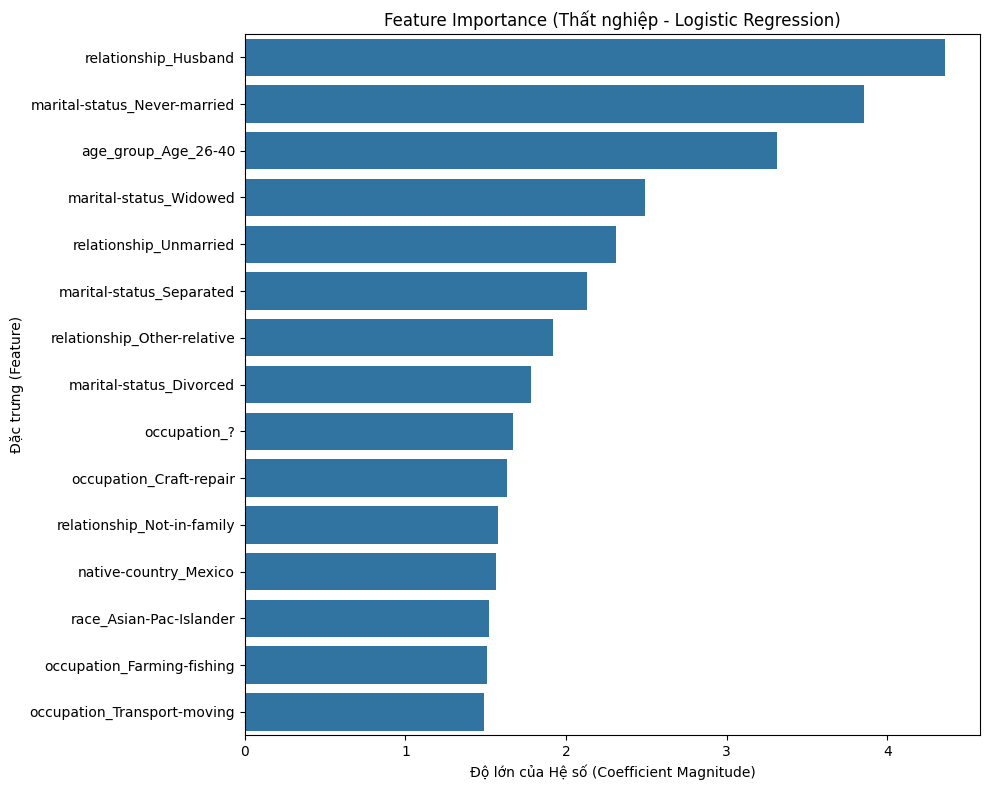

In [13]:
# OUTPUT 2: Vẽ và Lưu Biểu đồ Feature Importance
print("Đang tạo biểu đồ Feature Importance...")

# Với Logistic Regression, "importance" là độ lớn của hệ số (coefficient)
importances = np.abs(model.coef_[0])
feature_names = X_processed.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Feature Importance (Thất nghiệp - Logistic Regression)')
plt.xlabel('Độ lớn của Hệ số (Coefficient Magnitude)')
plt.ylabel('Đặc trưng (Feature)')
plt.tight_layout()
plt.savefig(UNEMPLOYMENT_CHART_PATH)
print(f"✅ OUTPUT 2: Đã lưu biểu đồ (Thất nghiệp) vào file.")
print("--- Quá trình huấn luyện hoàn tất! ---")